In [225]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import psycopg2
import seaborn as sns
sns.set_style("whitegrid")
import statsmodels.formula.api as sm
from urllib.parse import urlparse
from urllib import parse
from lib.build_export_features import ExportFeatureData
from lib.build_regressions_features_no_na import MixedFeatureData


%matplotlib inline
FOLLOWER_URL = os.environ['FOLLOWER_URL']
                          
def make_connection():
    url_output = FOLLOWER_URL
    url = urlparse(url_output)
    conn = psycopg2.connect(
        database=url.path[1:],
        user=url.username,
        password=url.password,
        host=url.hostname
    )
    return conn

In [ ]:
#Standardize Data
#Exclude None of These 
#Plot simulations for values with p <=.10
#Plot simulations for usage by itself (maybe bud by bud)
#Premiumness Plots

In [136]:
def trained_model(train_features, train_outcomes):
    np.random.seed(44)
    log_reg = sm.Logit(train_outcomes, train_features)
    param_array = np.zeros(len(train_features) + 1)
    iterations = 5
    for i in range(0, iterations):
        model = log_reg.fit(
            maxiter=5000, avextol=0.0001, epsilon=0.1, full_output=1, disp=0
        )
        params = list(model.params)
        param_array = [a + b for a, b in zip(param_array, params)]
        start = [p / iterations for p in param_array]
        model = log_reg.fit(
            start_params=start,
            maxiter=5000,
            avextol=0.0001,
            epsilon=0.1,
            full_output=1,
            disp=1,
        )
    return model


def odds_ratio(trained_model, independent_variables, independent_variables_indicies):
    sig_params = [
        trained_model.params[i]
        for i, col in enumerate(trained_model.params)
        if i in independent_variables_indicies
    ]
    odds_increase = [
        int(round(100 * (np.exp(param) - 1), 0)) for param in sig_params
    ]
    odds_ratio_table = pd.DataFrame(
        {
            "independent_variable": independent_variables,
            "odds_%_increase": odds_increase,
        }
    )
    # odds_ratio_table.to_string(index=False))
    return odds_ratio_table


def independent_variable_stats(feature_data, independent_variables):
    indep_stats = dict()
    for variable in independent_variables:
        std = feature_data[variable].std()
        mu = feature_data[variable].mean()
        indep_stats[variable] = {"mu": mu, "std": std}
    return indep_stats


def standardized_features(feature_data, independent_variables, stats):
    feature_copy = feature_data.copy()

    for indep in independent_variables:
        std = stats[indep]["std"]
        mu = stats[indep]["mu"]
        feature_copy[indep] = feature_copy.apply(
            lambda row: (row[indep] - mu) / std, axis=1
        )
        feature_copy[indep] = feature_copy[indep].fillna(-1)
    return feature_copy

In [234]:
def simulating_features(standardized_features, independent_variables):
    simulation_df = standardized_features[independent_variables].drop_duplicates()
    return simulation_df


def simulate_continuous_outcomes(
    standardized_features, trained_model, independent_variables, independent_variable
):
    outcome_labels = ["negative", "positive"]
    outcome_choices = [0, 1]
    simulation_df = standardized_features.sort_values(
        by=independent_variable
    ).reset_index()
    simulation_df["prediction"] = trained_model.predict(
        simulation_df[independent_variables]
    )

    indep_vals = (
        simulation_df.groupby([independent_variable])[
            "prediction"
        ]
        .mean()
        .reset_index()
    ).sort_values(by=independent_variable)
    response_range = indep_vals[independent_variable].tolist()
    predictions = indep_vals["prediction"].tolist()
    question_choices = indep_vals[independent_variable].tolist()
    return {
        "response_range": response_range,
        "predictions": predictions,
        "question_choices": question_choices,
    }

# START HERE
## The cell below contains all the mission specific data. Here you will specifity the mission id, the independent variables, the dependent variable, and the definitions of positive and negative outcome.

In [21]:
# CHANGE THESE VALUES
mission_id = "25614"
# ONLY USE SINGLE QUESTIONS FOR DEPENDENT AND INDEPENDENT VARIABLES IN FORMAT 'PART_NUM-QUESTION_NUM'
# ALL "4-4", "4-5","4-6", "4-10","4-11","4-12", "4-13","4-14","4-15","4-17","4-18","4-19","4-21"
continuous_independent_variables = [
    "4-4","4-6", "4-10","4-11","4-12", "4-13","4-14","4-15","4-17","4-18","4-21"
]
# NOTE MULTIPLE QUESTIONS NEED TO BE CATEGORICAL
categorical_independent_variables = []
binary_independent_variables = []
dependent_variable = "4-2"
negative_outcomes = [
"Moderately satisfied",
"Slightly satisfied",
"Neither satisfied nor dissatisfied",
"Slightly dissatisfied",
"Moderately dissatisfied",
"Extremely dissatisfied"
]
positive_outcomes = ["Extremely satisfied"]
demo_independent_variables = []
tag_independent_variables = []
#mutually exclusive scout groups only at this time
scout_group_independent_variables = []
#response_data = pd.read_pickle("mission_" + mission_id + "_data.pkl")
question_response_filtering = {}
grouping = 'user_id'
ethnicity_filters = []
education_filters = []
tag_filters = []
scout_group_filters = ["Pixel","Apple","Samsung","Bose"]

# After entering the information above, go to Cell -> Run All to see your regression results

In [22]:
cnc = make_connection()
questions = pd.read_sql_query(
    """with m_questions as (select id as question_id, label, type, position as question_position,
                            part_id, structure from questions where type in 
                            ('SingleQuestion', 'MultipleQuestion', 'NumberQuestion')
                            and mission_id = """
    + mission_id
    + """),
       m_parts as (select id as part_id, position as part_position from parts where
                   mission_id = """
    + mission_id
    + """)
    select question_id, label, type, question_position, m_parts.part_id, part_position,
    structure from m_questions join m_parts on m_questions.part_id = m_parts.part_id""",
    cnc,
)
print("collected questions")

question_list = (
    "(" + ",".join([str(a) for a in questions["question_id"].tolist()]) + ")"
)
snippets = pd.read_sql_query(
    """select id as snippet_id, user_id, assignment_id from snippets where mission_id = """
    + mission_id,
    cnc,
)
print("collected snippets")
scout_group_names = (
    "("
    + ",".join(["'" + str(sg) + "'" for sg in scout_group_independent_variables])
    + ")"
)
assignments = pd.read_sql_query(
    """select id as assignment_id, user_id from assignments where 
          mission_id = """
    + mission_id
    ,cnc)
assignment_list = "(" + ','.join([str(aid) for aid in assignments['assignment_id'].unique()]) +")"
assignment_groups = pd.read_sql_query(
    """select assignment_id, scout_group_id from assignments_scout_groups
    where assignment_id in """ + assignment_list,
    cnc
)
groups = pd.read_sql_query(
    """select id as scout_group_id, name as scout_group from scout_groups
    """,
    cnc)
scout_groups = pd.merge(
    assignment_groups,
    groups[groups['scout_group'].isin(scout_group_filters)],
    on='scout_group_id'
)
print("collected scout groups")


snippet_list = (
    "(" + ",".join([str(a) for a in snippets["snippet_id"].tolist()]) + ")"
)
responses = pd.read_sql_query(
    """select  id as response_id, snippet_id, question_id, 
    answers from responses where snippet_id in """
    + snippet_list,
    cnc,
)
print("collected responses")
snippets_tags = pd.read_sql_query(
    """Select tag_id, snippet_id from snippets_tags where snippet_id in """
    + snippet_list,
    cnc,
)
tag_list = "(" + ",".join([str(a) for a in snippets_tags["tag_id"].tolist()]) + ")"
tags = pd.read_sql_query(
    """select id as tag_id, name as tag from tags where id in """ + tag_list, cnc
)

snippets_tags = pd.merge(snippets_tags, tags, on="tag_id")
tagged_snippets = pd.merge(snippets, snippets_tags, on="snippet_id", how="left")
user_list = "(" + ",".join([str(a) for a in assignments["user_id"].tolist()]) + ")"
users = pd.read_sql_query(
    """select id as user_id, ethnicity, education, household_income, birthday, gender from users where
                                 id in """
    + user_list,
    cnc,
)
user_snippets = pd.merge(tagged_snippets, users, on="user_id", how="left")
user_snippets = pd.merge(user_snippets, scout_groups, on="assignment_id", how="left")
response_data = pd.merge(responses, questions, on="question_id")
response_data = pd.merge(response_data, user_snippets, on="snippet_id", how="left")
cnc.close

collected questions
collected snippets
collected scout groups
collected responses


<function connection.close>

In [23]:
response_data['birthday'] = response_data['birthday'].astype('datetime64[ns]')

In [84]:
response_data

,response_id,snippet_id,question_id,answers,label,type,question_position,part_id,part_position,structure,...,assignment_id,tag_id,tag,ethnicity,education,household_income,birthday,gender,scout_group_id,scout_group
0,24634639,1407897,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200386,NaN,NaN,white,post_grad,lower_high,1986-03-16,male,23601,Pixel
1,24639368,1408011,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200370,NaN,NaN,white,hs_grad,low,1955-08-23,male,23601,Pixel
2,24641382,1408042,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200277,NaN,NaN,black,some_col,middle,1996-01-18,male,23600,Bose
3,24641817,1408053,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200308,NaN,NaN,white,post_grad,middle,1985-06-08,male,23601,Pixel
4,24642375,1408072,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200384,NaN,NaN,white,hs_grad,middle,1999-12-10,male,23602,Samsung
5,24643151,1408093,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200379,NaN,NaN,white,some_col,upper_middle,1997-07-31,male,23599,Apple
6,24643200,1408096,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200338,NaN,NaN,hispanic,some_col,middle,1984-07-17,female,23599,Apple
7,24644214,1408128,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200484,NaN,NaN,white,post_grad,upper_middle,1988-08-18,male,23601,Pixel
8,24644842,1408153,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200421,NaN,NaN,black,some_col,lower_middle,1981-10-13,female,23600,Bose
9,24645223,1408171,360418,"[Yes, I have received my package, and promise ...",Check below to officially indicate that you ha...,SingleQuestion,1,37058,0,"{'other': '', 'skips': [], 'choices': ['Yes, I...",...,1200405,NaN,NaN,white,col_grad,upper_middle,1989-06-04,female,23600,Bose


In [24]:
fd = MixedFeatureData(
    response_data,
    dependent_variable,
    continuous_independent_variables,
    binary_independent_variables,
    categorical_independent_variables,
    positive_outcomes,
    negative_outcomes,
    demo_independent_variables,
    tag_independent_variables,
    scout_group_independent_variables,
    grouping,
)
export = MixedFeatureData(
    response_data,
    dependent_variable,
    continuous_independent_variables,
    binary_independent_variables,
    categorical_independent_variables,
    positive_outcomes,
    negative_outcomes,
    demo_independent_variables,
    tag_independent_variables,
    scout_group_independent_variables,
    grouping,
)

In [25]:
part_3 = pd.read_csv(
    'mission_25614_part_3_data.csv'
)
part_4 = pd.read_csv(
    'mission_25614_part_4_data.csv'
)

In [26]:
part_4['outcome'] = part_4.apply(
    lambda row: 1 if row['4-2'] == 'Extremely satisfied'
    else 0,
    axis = 1
)

In [60]:
all_p3_cols = [
    col for col in list(part_3) if (len(col) > 3 and 
    (col.startswith('3-2') or col.startswith('3-3') 
    or col.startswith('3-4'))) and not col.endswith('other')
    and not col.endswith('None of these')
]
col_sum = part_3[all_p3_cols].sum().reset_index()
p3_cols = col_sum[col_sum[0] > 10]['index'].tolist()


In [146]:
part_3_filtered = part_3.copy()
part_3_filtered['sum_1'] = part_3_filtered.apply(
    lambda row: np.sum(row[all_p3_cols]),
    axis=1
)
part_3_filtered['sum_2'] = part_3_filtered.apply(
    lambda row: np.sum(row[p3_cols]),
    axis=1
)

In [150]:
part_3_filtered[(part_3_filtered["sum_1"] != 0) & (part_3_filtered["sum_2"] != 0)]

,Unnamed: 0,snippet_id,user_id,assignment_id,tag_id,tag,ethnicity,education,household_income,birthday,...,3-2_Watching TV or movies,3-2_other,3-4_Companion app for the earbud,"3-4_Gesture/touch controls (e.g., swipe, tap, etc.)",3-4_None of these,"3-4_Removable/adjustable features designed to help fit the earbuds (e.g., ear tips, stabilizers, cord loops, etc.)","3-4_Standalone media playing (i.e., storing music directly on the earbuds)","3-4_Voice assistant (e.g., Siri, Bixby, Google Assistant, etc.)",sum_1,sum_2
0,0,1415044,192112,1200468,NaN,NaN,hispanic,col_grad,lower_high,1982-01-19,...,0,0,0,0,1,0,0,0,2,2
1,1,1415142,289308,1200295,NaN,NaN,white,some_col,low,1994-12-15,...,0,0,0,0,0,0,1,0,5,5
2,2,1415253,305761,1200449,NaN,NaN,white,some_col,upper_middle,1980-08-03,...,1,0,0,1,0,1,0,1,11,11
3,3,1415276,292828,1200401,NaN,NaN,hispanic,some_col,middle,1986-01-25,...,0,0,0,1,0,0,0,1,8,8
4,4,1415293,299353,1200480,NaN,NaN,hispanic,col_grad,low,1982-12-28,...,1,0,0,0,0,0,0,1,6,6
5,5,1415312,306107,1200366,NaN,NaN,white,col_grad,NaN,1996-04-05,...,0,0,0,0,1,0,0,0,4,4
6,6,1415326,274702,1200415,NaN,NaN,white,col_grad,high,1964-10-13,...,0,1,0,0,0,1,0,0,5,5
7,7,1415334,299229,1200347,NaN,NaN,hispanic,hs_grad,lower_middle,1999-01-25,...,0,0,1,0,0,0,1,1,9,9
8,8,1415355,274702,1200415,NaN,NaN,white,col_grad,high,1964-10-13,...,0,1,0,0,0,1,0,0,5,5
9,9,1415356,255104,1200398,NaN,NaN,hispanic,col_grad,upper_middle,1981-04-15,...,1,0,1,0,0,0,0,0,5,5


In [61]:
p3_cols

['3-3_Charged my earbuds',
 '3-3_Got updates on my schedule, traffic, weather, etc.',
 '3-3_Listened to music/podcasts',
 '3-3_Listened to news updates',
 '3-3_Made a call',
 '3-3_Sent/received a text message',
 '3-3_Tracked my health/fitness',
 '3-2_Commuting to and from work',
 '3-2_Exercising',
 '3-2_Getting work done',
 '3-2_Relaxing',
 '3-2_Traveling longer distances',
 '3-2_Watching TV or movies',
 '3-4_Companion app for the earbud',
 '3-4_Gesture/touch controls (e.g., swipe, tap, etc.)',
 '3-4_Removable/adjustable features designed to help fit the earbuds (e.g., ear tips, stabilizers, cord loops, etc.)',
 '3-4_Standalone media playing (i.e., storing music directly on the earbuds)',
 '3-4_Voice assistant (e.g., Siri, Bixby, Google Assistant, etc.)']

In [151]:
p3_max_features = pd.merge(
    part_3_filtered[(part_3_filtered["sum_1"] != 0) & (part_3_filtered["sum_2"] != 0)][
        p3_cols + ["user_id", "scout_group"]
    ]
    .groupby("user_id")
    .max()
    .reset_index(),
    part_4[["user_id", "outcome"]],
    on="user_id",
)
p3_max_stats = independent_variable_stats(p3_max_features, p3_cols)
p3_max_std = standardized_features(p3_max_features, p3_cols, p3_max_stats)
p3_sum_features = pd.merge(
    part_3_filtered[(part_3_filtered["sum_1"] != 0) & (part_3_filtered["sum_2"] != 0)][
        p3_cols + ["user_id", "scout_group"]
    ]
    .groupby("user_id")
    .sum()
    .reset_index(),
    part_4[["user_id", "outcome"]],
    on="user_id",
)
p3_sum_stats = independent_variable_stats(p3_sum_features, p3_cols)
p3_sum_std = standardized_features(p3_sum_features, p3_cols, p3_sum_stats)
avg_usage = pd.merge(
    fd.encoded_features,
    part_3[(part_3["3-5"] >= 0) & (part_3["3-5"] < 1440)][
        ["user_id", "snippet_id", "scout_group", "3-5"]
    ]
    .groupby(["user_id", "snippet_id", "scout_group"])
    .mean()
    .reset_index(),
    on="user_id",
)
avg_usage_stats = independent_variable_stats(
    avg_usage, ["3-5"] + fd.independent_variables
)
avg_usage_std = standardized_features(
    avg_usage, ["3-5"] + fd.independent_variables, avg_usage_stats
)

In [152]:
max_model = trained_model(p3_max_std[p3_cols], p3_max_std["outcome"])
max_model = trained_model(p3_max_std[p3_cols], p3_max_std["outcome"])
sum_model = trained_model(p3_sum_std[p3_cols], p3_sum_std["outcome"])
sum_model = trained_model(p3_sum_std[p3_cols], p3_sum_std["outcome"])
usage_model = trained_model(
    avg_usage_std[["3-5"] + fd.independent_variables], avg_usage_std["outcome"]
)
usage_model = trained_model(
    avg_usage_std[["3-5"] + fd.independent_variables], avg_usage_std["outcome"]
)
usage_only_model = trained_model(
    avg_usage_std[["3-5"]], avg_usage_std["outcome"]
)
usage_only_model = trained_model(
    avg_usage_std[["3-5"]], avg_usage_std["outcome"]
)
usage_apple_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Apple'][["3-5"]], 
    avg_usage[avg_usage_std['scout_group'] == 'Apple']["outcome"]
)
usage_apple_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Apple'][["3-5"]],
    avg_usage[avg_usage_std['scout_group'] == 'Apple']["outcome"]
)
usage_bose_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Bose'][["3-5"]],
    avg_usage[avg_usage_std['scout_group'] == 'Bose']["outcome"]
)
usage_bose_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Bose'][["3-5"]],
    avg_usage[avg_usage_std['scout_group'] == 'Bose']["outcome"]
)
usage_samsung_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Samsung'][["3-5"]],
    avg_usage[avg_usage_std['scout_group'] == 'Samsung']["outcome"]
)
usage_samsung_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Samsung'][["3-5"]],
    avg_usage[avg_usage_std['scout_group'] == 'Samsung']["outcome"]
)
usage_pixel_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Pixel'][["3-5"]],
    avg_usage[avg_usage_std['scout_group'] == 'Pixel']["outcome"]
)
usage_pixel_model = trained_model(
    avg_usage_std[avg_usage_std['scout_group'] == 'Pixel'][["3-5"]],
    avg_usage[avg_usage_std['scout_group'] == 'Pixel']["outcome"]
)

Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658479
  

In [153]:
print(max_model.summary())
sig_indicies = [i for i,p in enumerate(max_model.pvalues) if p <= .10]
sig_variables = [
        p3_cols[i]
        for i, col in enumerate(p3_cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(max_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  951
Model:                          Logit   Df Residuals:                      933
Method:                           MLE   Df Model:                           17
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:                 0.04369
Time:                        16:00:11   Log-Likelihood:                -626.21
converged:                       True   LL-Null:                       -654.82
                                        LLR p-value:                 3.003e-06
                                                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3-

In [154]:
print(sum_model.summary())
sig_indicies = [i for i,p in enumerate(sum_model.pvalues) if p <= .10]
sig_variables = [
        p3_cols[i]
        for i, col in enumerate(p3_cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(sum_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  951
Model:                          Logit   Df Residuals:                      933
Method:                           MLE   Df Model:                           17
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:                 0.05241
Time:                        16:00:19   Log-Likelihood:                -620.50
converged:                       True   LL-Null:                       -654.82
                                        LLR p-value:                 3.694e-08
                                                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3-

In [155]:
print(usage_model.summary())
cols = ['3-5'] + fd.independent_variables
sig_indicies = [i for i,p in enumerate(usage_model.pvalues) if p <= .10]
sig_variables = [
        cols[i]
        for i, col in enumerate(cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(usage_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 3055
Model:                          Logit   Df Residuals:                     3043
Method:                           MLE   Df Model:                           11
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:                  0.4027
Time:                        16:00:32   Log-Likelihood:                -1258.7
converged:                       True   LL-Null:                       -2107.1
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
3-5           -0.0764      0.050     -1.536      0.124      -0.174       0.021
4-4            0.6195      0.075      8.304      0.000       0.473       0.766
4-6            1.0017      0.066     15.101      0.0

In [168]:
print(usage_only_model.summary())
cols = ['3-5'] 
sig_indicies = [i for i,p in enumerate(usage_only_model.pvalues) if p <= .10]
sig_variables = [
        cols[i]
        for i, col in enumerate(cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(usage_only_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 3055
Model:                          Logit   Df Residuals:                     3054
Method:                           MLE   Df Model:                            0
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:               -0.004355
Time:                        16:03:37   Log-Likelihood:                -2116.3
converged:                       True   LL-Null:                       -2107.1
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
3-5           -0.0587      0.036     -1.619      0.105      -0.130       0.012

ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [independent_variable, odds_%_increase]
Index: []


In [167]:
print(usage_apple_model.summary())
cols = ['3-5'] 
sig_indicies = [i for i,p in enumerate(usage_apple_model.pvalues) if p <= .10]
sig_variables = [
        cols[i]
        for i, col in enumerate(cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(usage_apple_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  715
Model:                          Logit   Df Residuals:                      714
Method:                           MLE   Df Model:                            0
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:                -0.01584
Time:                        16:03:30   Log-Likelihood:                -495.59
converged:                       True   LL-Null:                       -487.86
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
3-5           -0.0096      0.076     -0.126      0.900      -0.159       0.139

ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [independent_variable, odds_%_increase]
Index: []


In [166]:
print(usage_bose_model.summary())
cols = ['3-5'] 
sig_indicies = [i for i,p in enumerate(usage_bose_model.pvalues) if p <= .10]
sig_variables = [
        cols[i]
        for i, col in enumerate(cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(usage_bose_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  774
Model:                          Logit   Df Residuals:                      773
Method:                           MLE   Df Model:                            0
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:               -0.002748
Time:                        16:03:22   Log-Likelihood:                -536.08
converged:                       True   LL-Null:                       -534.61
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
3-5           -0.0676      0.074     -0.911      0.362      -0.213       0.078

ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [independent_variable, odds_%_increase]
Index: []


In [165]:
print(usage_samsung_model.summary())
cols = ['3-5'] 
sig_indicies = [i for i,p in enumerate(usage_samsung_model.pvalues) if p <= .10]
sig_variables = [
        cols[i]
        for i, col in enumerate(cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(usage_samsung_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  735
Model:                          Logit   Df Residuals:                      734
Method:                           MLE   Df Model:                            0
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:                0.004153
Time:                        16:03:13   Log-Likelihood:                -505.97
converged:                       True   LL-Null:                       -508.08
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
3-5           -0.1922      0.073     -2.627      0.009      -0.336      -0.049

ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~
  independent_variable  odds_%_increase
0                  3-5              -17


In [119]:
print(usage_pixel_model.summary())
cols = ['3-5'] 
sig_indicies = [i for i,p in enumerate(usage_model.pvalues) if p <= .10]
sig_variables = [
        cols[i]
        for i, col in enumerate(cols)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(usage_only_model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  831
Model:                          Logit   Df Residuals:                      830
Method:                           MLE   Df Model:                            0
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:                -0.07658
Time:                        15:34:12   Log-Likelihood:                -575.93
converged:                       True   LL-Null:                       -534.96
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
3-5            0.0260      0.068      0.383      0.702      -0.107       0.159

ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~
  independent_variable  odds_%_increase
0                  3-5                3


In [195]:
def get_question_choices(structure):
    try:
        return structure["choices"][::-1]
    except KeyError:
        return [int(i) for i in np.linspace(0, 100, 101)]

In [ ]:
processed_data = fd.processed()

In [203]:
question_df = processed_data.groupby("question_name")["structure"].first().reset_index()
question_df["choices"] = question_df.apply(
    lambda row: get_question_choices(row["structure"]), axis=1
)
choice_dict = dict(
    zip(question_df["question_name"].tolist(), question_df["choices"].tolist())
)

In [176]:
p3_sum_simulating_features = simulating_features(p3_sum_std, p3_cols)

In [221]:
simulate_continuous_outcomes(
    p3_sum_simulating_features, sum_model, p3_cols,  p3_cols[0]
)

{'response_range': [-1.9108705609343763,
  -1.2805417702827662,
  -0.6502129796311561,
  -0.019884188979545938,
  0.6104446016720642,
  1.2407733923236743],
 'predictions': [0.5265651463755724,
  0.5035347887842061,
  0.48738941786637663,
  0.49455579557138174,
  0.4885932936075714,
  0.5103898143460899],
 'question_choices': [-1.9108705609343763,
  -1.2805417702827662,
  -0.6502129796311561,
  -0.019884188979545938,
  0.6104446016720642,
  1.2407733923236743]}

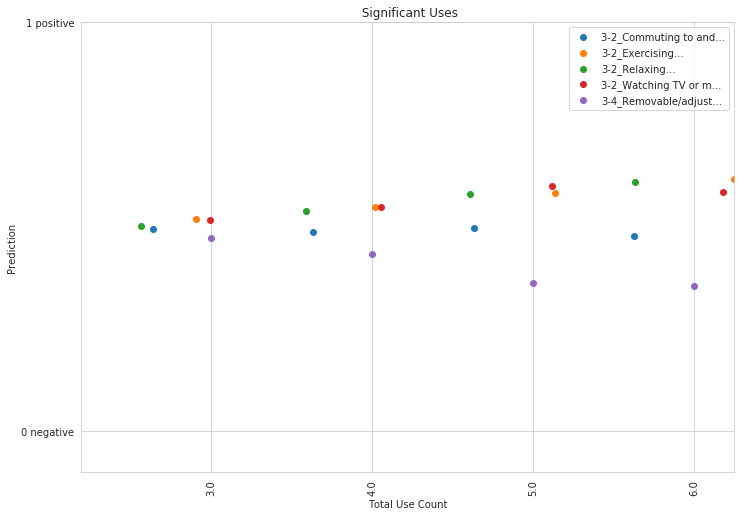

In [250]:
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sig_indicies = [i for i, p in enumerate(sum_model.pvalues) if p <= 0.10]
sig_variables = [p3_cols[i] for i, col in enumerate(p3_cols) if i in sig_indicies]
for independent_variable in sig_variables:
    outcome_labels = ["negative", "positive"]
    outcome_choices = [0, 1]
    r_d = simulate_continuous_outcomes(
        p3_sum_simulating_features, sum_model, p3_cols, independent_variable
    )
    ax.scatter(
        r_d["response_range"],
        r_d["predictions"],
        label=independent_variable[0:20] + "...",
    )
    ax.set_ylabel("Prediction")
    ax.set_xlabel("Total Use Count")
    ax.set_yticks(np.sort(outcome_choices))
    ax.set_yticklabels(
        [
            str(outcome) + " " + choice
            for outcome, choice in zip(outcome_choices, outcome_labels)
        ]
    )
    ax.set_xticks(np.sort(r_d["response_range"]))
    ax.set_xticklabels(
        [
            round(
                p3_sum_stats[independent_variable]["std"]
                * (p3_sum_stats[independent_variable]["mu"] + chc)
            )
            for chc in r_d["question_choices"]
        ],
        rotation=90,
    )
    ax.legend()
    ax.set_title(" Significant Uses")
    ax.set_ylim(-0.1)
    ax.set_xlim(-0.1)
plt.savefig("sig_sum_uses.png")
plt.show()

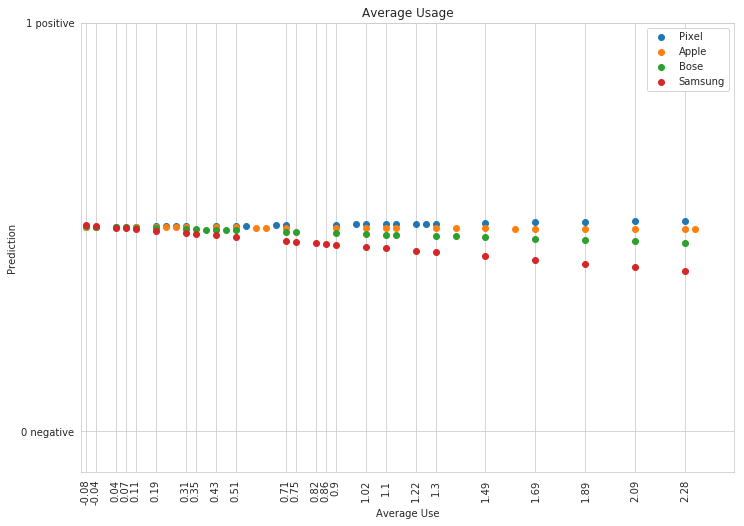

In [261]:
bud_models = {
    'Pixel': usage_pixel_model,
    'Apple': usage_apple_model,
    'Bose': usage_bose_model,
    'Samsung': usage_samsung_model
}
fig, ax = plt.subplots(figsize=a4_dims)
independent_variable = '3-5'
stats = independent_variable_stats(
        avg_usage_std, ["3-5"]
) 
for model in list(bud_models):
    outcome_labels = ["negative", "positive"]
    outcome_choices = [0, 1]
    bud_df = avg_usage_std[avg_usage_std['scout_group'] == model]   
    bud_simulating_features = simulating_features(
        bud_df,
        ['3-5']
    )
    r_d = simulate_continuous_outcomes(
       bud_simulating_features, bud_models[model], ['3-5'], independent_variable
    )
    ax.scatter(
        r_d["response_range"],
        r_d["predictions"],
        label=model
    )
    ax.set_ylabel("Prediction")
    ax.set_xlabel("Average Use")
    ax.set_yticks(np.sort(outcome_choices))
    ax.set_yticklabels(
        [
            str(outcome) + " " + choice
            for outcome, choice in zip(outcome_choices, outcome_labels)
        ]
    )
    ax.set_xticks(np.sort(r_d["response_range"]))
    ax.set_xticklabels(
        [
            round(
                stats[independent_variable]["std"]
                * (stats[independent_variable]["mu"] + chc), 2
            )
            for chc in r_d["question_choices"]
        ],
        rotation=90,
    )
    ax.legend()
    ax.set_title("Average Usage")
    ax.set_ylim(-0.1)
    ax.set_xlim(-0.1)
plt.savefig("bud_usage.png")
plt.show()

In [258]:
stats

{'3-5': {'mu': 0.03989062453788135, 'std': 1.0224053426029824}}